In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
library(ggsci)
library(rstatix)
library(ggpubr)
library(ggplot2) 
library(GGally) 
library(pheatmap)


Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘reshape2’ was built under R version 4.3.3”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Warning message:
“package ‘ggsci’ was built under R version 4.3.3”
Warning message:
“package ‘rstatix’ was built under R version 4.3.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘GGally’ was built under R version 4.3.3”
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
“package ‘pheatmap’ was built under R version 4.3.3”


In [3]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [4]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(' cell','',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read composite score

In [5]:
df<-read.csv('../Figure1/04_CompositeScore/BRI_CompositeScore_Up.csv') %>% 
filter(sample.visitName=='Flu Year 1 Day 0')

In [6]:
unique(df$celltype)

[1] "CM CD4 T cell"             "CM CD8 T cell"            
[3] "Core naive CD4 T cell"     "Core naive CD8 T cell"    
[5] "GZMB- CD27- EM CD4 T cell" "GZMB- CD27+ EM CD4 T cell"
[7] "GZMK+ CD27+ EM CD8 T cell" "Naive CD4 Treg"

In [ ]:
df

In [6]:
df$celltype<-gsub(' cell','',df$celltype)
celltype_order <- c("Core naive CD8 T", 
                    "CM CD8 T", 
                    "GZMK+ CD27+ EM CD8 T",
                    "Naive CD4 Treg",
                    "Core naive CD4 T",
                    "CM CD4 T",
                    "GZMB- CD27- EM CD4 T",
                    "GZMB- CD27+ EM CD4 T")
celltype_order <- c("Core naive CD8 T", 
                    "Core naive CD4 T",
                    "CM CD8 T",
                    "CM CD4 T",
                    "Naive CD4 Treg",
                    "GZMK+ CD27+ EM CD8 T",
                    "GZMB- CD27- EM CD4 T",
                    "GZMB- CD27+ EM CD4 T")
df$celltype <- factor(df$celltype,levels=celltype_order)


# Plotting

In [7]:
STAT_res <- df[c('composite_score_sum_scaled_mean','celltype','cohort.cohortGuid')] %>%
    dplyr::group_by(celltype) %>%
    wilcox_test(composite_score_sum_scaled_mean ~ cohort.cohortGuid, paired = FALSE) %>%
    adjust_pvalue(method = 'BH') %>%
    add_xy_position() %>%
    add_significance() %>%mutate(p.adj = format(p.adj, scientific = TRUE, digits = 3))

In [8]:
STAT_res

celltype             .y.                             group1 group2 n1 n2
1 Core naive CD8 T     composite_score_sum_scaled_mean BR1    BR2    47 45
2 Core naive CD4 T     composite_score_sum_scaled_mean BR1    BR2    47 45
3 CM CD8 T             composite_score_sum_scaled_mean BR1    BR2    47 45
4 CM CD4 T             composite_score_sum_scaled_mean BR1    BR2    47 45
5 Naive CD4 Treg       composite_score_sum_scaled_mean BR1    BR2    47 45
6 GZMK+ CD27+ EM CD8 T composite_score_sum_scaled_mean BR1    BR2    47 45
7 GZMB- CD27- EM CD4 T composite_score_sum_scaled_mean BR1    BR2    47 45
8 GZMB- CD27+ EM CD4 T composite_score_sum_scaled_mean BR1    BR2    47 45
  statistic p        p.adj    y.position groups <NA> <NA> <NA> <NA> <NA> <NA>
1 370       1.64e-08 1.87e-08 166.6724   BR1    BR1  BR1  BR1  BR1  BR1  BR1 
2 382       3.12e-08 3.12e-08 158.0074   BR2    BR2  BR2  BR2  BR2  BR2  BR2 
3 254       1.17e-11 3.12e-11 116.1264   BR1    BR1  BR1  BR1  BR1  BR1  BR1 
4 274       4.76e-11 7.62e-11 217.6184   BR2    BR2  BR2  BR2  BR2  BR2  BR2 
5  91       2.61e-18 2.09e-17 129.5274   BR1    BR1  BR1  BR1  BR1  BR1  BR1 
6 278       6.24e-11 8.32e-11  50.3744   BR2    BR2  BR2  BR2  BR2  BR2  BR2 
7 270       3.62e-11 7.24e-11  66.8204   BR1    BR1  BR1  BR1  BR1  BR1  BR1 
8 212       4.78e-13 1.91e-12  74.8614   BR2    BR2  BR2  BR2  BR2  BR2  BR2 
  <NA> xmin xmax p.adj.signif
1 BR1  1    2    ****        
2 BR2  1    2    ****        
3 BR1  1    2    ****        
4 BR2  1    2    ****        
5 BR1  1    2    ****        
6 BR2  1    2    ****        
7 BR1  1    2    ****        
8 BR2  1    2    ****

In [9]:
df <- df %>% dplyr::mutate(`Age Group` = case_when(
  cohort.cohortGuid == "BR1" ~ "Young",
  cohort.cohortGuid == "BR2" ~ "Older",
  TRUE ~ NA_character_
))
df$`Age Group`<-factor(df$`Age Group`,levels=rev(c("Young","Older")))

In [14]:
df$RNA_Age_Metric_Up<-df$composite_score_sum_scaled_mean
write.csv(df %>% select(pbmc_sample_id,celltype,RNA_Age_Metric_Up,`Age Group`),
          "/home//workspace/Source_Data/Extended_Fig3b_1.csv", 
          row.names=FALSE)

Warning message in geom_point(aes(linetype = `Age Group`, x = composite_score_sum_scaled_mean), :
“Ignoring unknown aesthetics: linetype”


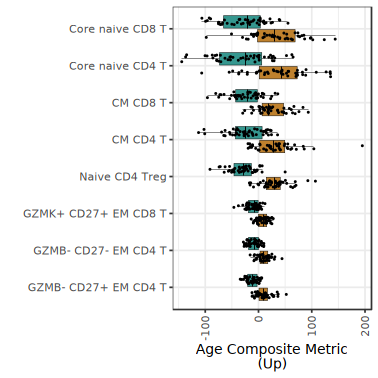

In [10]:
options(repr.plot.width = 80/25.4, repr.plot.height =  80/25.4)
df$celltype <- factor(df$celltype,levels=rev(celltype_order))

p<-ggplot(df ,aes(y = celltype, x = composite_score_sum_scaled_mean,color = `Age Group`)) +
    geom_boxplot( lwd=0.1, outlier.shape = NA,aes(fill = `Age Group`),color='black') +
    theme_bw(base_size = 8)+theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +   
    theme(legend.position = "none")+
   geom_point(aes(linetype = `Age Group`, x = composite_score_sum_scaled_mean), 
     position = position_jitterdodge(dodge.width=0.8), color='black', size=0.55, stroke=0)+
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f')) +xlab('Age Composite Metric\n(Up)')+ylab('')
p
ggsave('FigureB1.pdf',p,width = 80/25.4, height =  80/25.4)

In [11]:
options(repr.plot.width = 170/25.4, repr.plot.height =  70/25.4)

p <- ggplot(df ,
              aes(x = `Age Group`, y = composite_score_sum_scaled_mean)) +
    geom_boxplot( lwd=0.3, outlier.shape = NA,aes(fill = `Age Group`))+
    geom_point(aes(y = composite_score_sum_scaled_mean), 
               position = position_jitter(width = 0.2), color="black", size=0.5, stroke=0) +
    facet_wrap(~ celltype, scales = 'free_y', ncol = 4) +   
    stat_pvalue_manual(STAT_res, size=2.2,  bracket.size=0,
                       label = "adj.p = {p.adj}", 
                       tip.length = 0) +
    theme_classic(base_size = 7) +
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f')) +
    scale_y_continuous(limits = c(NA, NA), expand = expansion(mult = c(0.1, 0.15)))+ylab('Age Composite Metric (Up)')+ 
guides(shape = guide_legend(override.aes = list(size = 0.5)))+
    theme(axis.line = element_line(colour = "black", linewidth = 0.1),
          legend.position = "top",
          legend.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          strip.background = element_rect(linewidth = 0),
          axis.title.x = element_text(margin = margin(t = 2)),
         strip.text = element_text(size = 7))



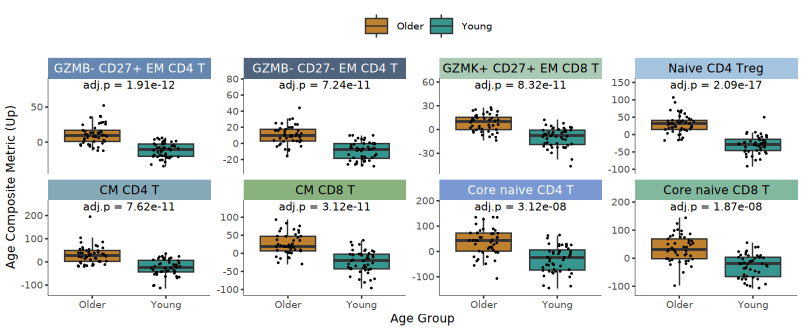

In [15]:
plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))
strip_labels <- sapply(strips, function(i) {
  plot$grobs[[i]]$grobs[[1]]$children[[2]]$children[[1]]$label
})
#strip_labels<-gsub(' cell','',strip_labels)

pal <- color_vector[strip_labels]
text_color <- sapply(color_vector[strip_labels], is_dark_color)

strip_names <- plot$layout$name[strips]


for (i in seq_along(strips)) {
  strip_name <- strip_names[i]

  
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  
  adjusted_color <- adjustcolor(pal[i], alpha.f = 0.8)
  
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjusted_color
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
